# hold_peaks

Set's the value of each voxel to the highest value that is found on the voxel's axis. The axis used is selected in the input.

## Import packages

In [1]:
import numpy as np
import porespy as ps
import scipy.ndimage as spim
import matplotlib.pyplot as plt
import skimage

## Create image and variables:

--------------------------------------------------------------------------------
RSA: Adding spheres of size 5
Initial volume fraction: 0.0
Dilating foreground features by sphere radius
Number of spheres inserted: 392
Final volume fraction: 0.3005333333333333


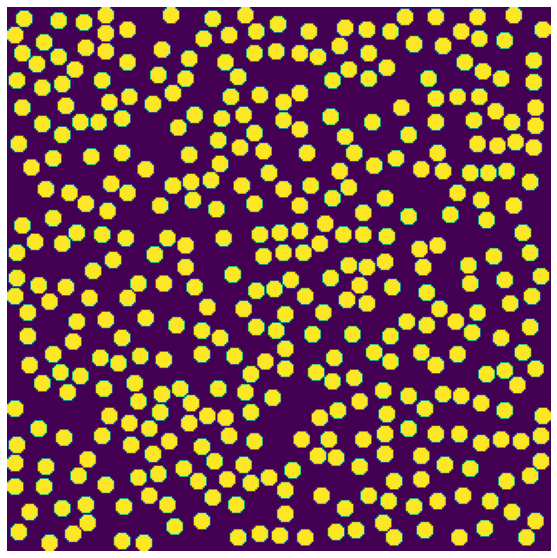

In [2]:
im = np.zeros([300, 300])
im = ps.generators.RSA(im, radius=5, volume_fraction=0.3)
im = im.astype(np.float32)
plt.figure(figsize=[10, 10])
plt.axis(False)
plt.imshow(im)

#default values:
axis=-1

## Apply filter function:
With different parameters

Text(0.5, 1.0, 'axis = 0')

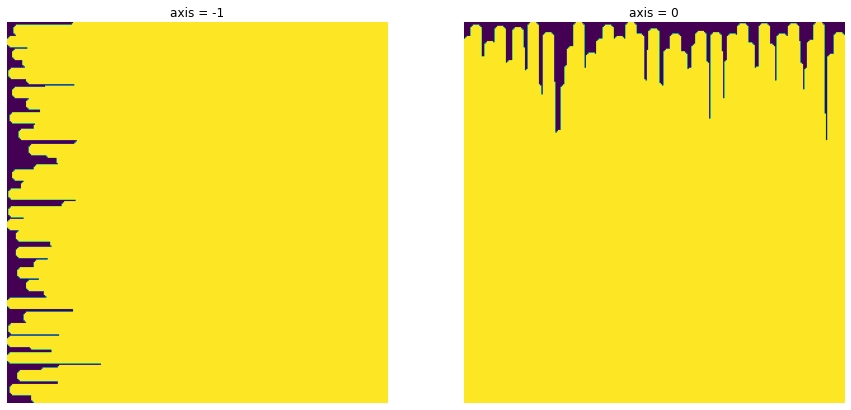

In [4]:
x = ps.filters.hold_peaks(im, axis)
xx = ps.filters.hold_peaks(im, 0)

fig, ax = plt.subplots(1, 2, figsize=[15, 15]);
ax[0].imshow(x);
ax[1].imshow(xx);
ax[0].axis(False)
ax[1].axis(False)
ax[0].set_title('axis = -1')
ax[1].set_title('axis = 0')